# Data Science Project 1 - Seattle AirBNB

### 1. Business Understanding - Questions
In this notebook I will be examining AirBNB data for Seattle to answer the following questions. 

1. Does the listing price vary for hosts with multiple listings compared to hosts with only 1 listing? 
    1a. Are hosts with multiple listings concentrated in certain Seattle areas?
2. Do renters prefer certain property features or amenities?
3. Which factors contribute the most to Seattle's AirBNB property rental price? 
    3b. How well can we predict a property's rental price?

Understanding these questions could help those currently listing property in Seattle on AirBNB improve their future earnings, or give newbees an idea of what they should focus on to make the best return on their rentals.

### 2. Data Understanding
Firstly, I need to load in supporting data modelling and visualisation packages and read in the raw Seattle data. 
Then have a look at the top 5 rows of each dataset. I am using `pd.set_option('max_columns', None)` to make all columns visible, as opposed to summary view, where some may be hidden.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import airbnb_functions as abnb #python file containing supporting functions I have written to help cleanse the data
%matplotlib inline

listings_df = pd.read_csv('./Seattle_AirBND_Data/listings.csv')
calendar_df = pd.read_csv('./Seattle_AirBND_Data/calendar.csv')
reviews_df = pd.read_csv('./Seattle_AirBND_Data/reviews.csv')

pd.set_option('max_columns', None) #allows all columns to be visible
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [2]:
listings_df.shape

(3818, 92)

Property listings will be the primary dataset used since it contains both review summarised review scores and price, which I will need for the last 2 questions, as well many other columns which could be helpful.

In [3]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


The calendar data shows the changing price and availability of the properties over time, which could be useful to calculate an adjustment for the impact of inflation/increases in property values factor into future pricing. I would otherwise ignore this data since the listings dataset includes current price and availability per 30/60 or 90 days. 

In [4]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


Although the listings data includes review scores, the above data could be useful if it is possible to pull out common words associated positives or negative listing review scores, to see what issues or nice experiences renters have commented on in the past.

#### A Closer Look
The below table allows me to closer examine the listings' columns and data types.<br><br>
The function used summarises the listings_df columns into a new dataframe. Adding the count of non-null values, column population percentage, number of unique values per column and data type to a table. <br><br>
This will help to identify those columns which need to be tidyied, or can be ignored as unlikely to contribute to the questions I am trying to answer.

In [5]:
pd.set_option('max_rows', None) #View all rows

listings_info = abnb.summerize_columns(listings_df)
listings_info

,colName,non-null values,pop percentage,unique,dtype
0,id,3818,1.000000,3818,int64
1,listing_url,3818,1.000000,3818,object
2,scrape_id,3818,1.000000,1,int64
3,last_scraped,3818,1.000000,1,object
4,name,3818,1.000000,3792,object
5,summary,3641,0.953641,3478,object
6,space,3249,0.850969,3119,object
7,description,3818,1.000000,3742,object
8,experiences_offered,3818,1.000000,1,object
9,neighborhood_overview,2786,0.729701,2506,object


In [6]:
pd.reset_option('max_rows') #Reset number of rows shown
most_missing_cols = set(listings_df.columns[listings_df.isnull().mean()>0.75])
print(most_missing_cols)

{'square_feet', 'license'}


From the above cells' output I can make the following conclusions.

1. `Licence` is null and can be removed since it adds no value. 
2. Likewise columns `scrape_id`, `last_scraped`, `experiences_offered`, `market`, `country_code`, `country`, `has_availability`, `calendar_last_scraped`, `requires_licence`, `jurisdiction_names` all have only 1 unique value so can be removed.
3. `Id` is the unique identifier and maps to the `calender` and `review` datasets. This could be used to merge the 3 dataframes later on, though would need to be removed from any predictor model.
4. `square_feet` has less that 25% values and could possibly be ignored. 
5. Columns `price`, `weekly_price`, `monthly_price`, `security_deposit`, `cleaning_fee`, `extra_people`, `host_response_rate` and `host_acceptance_rate` are all objects instead of numerical types, which they appeared to be in the `listing_df.head()`. They will need to be converted to make the data easier to work with. 
6. `listing_url` is basically a duplicate of `id` adding no additional value so can be removed.
7. `host_total_listings_count` is also a duplicate of `host_listings_count`
8. Weirdly it looks like there are 7 unique values for `city` and 2 for `state`, where I would have assumed they should all be the same and could therefore be ignored. Worth a look.

I can also see that every listing has at least 1 picture url, though 91.6% also have a thumbnail, medium and xl picture. While I think that good or bad pictures are likely to influence renters it is a bit beyond the scope of this project to class them as such, and correlate them to review_accuracy_scores. For now I will exclude them and replace them with a dummy variable showing whether the listings have additional pictures or not.<br>
In the future, I could manually go through the photos and classify them as good/appealing or not, or containing additional features. I could also use a cnn deep learning model, and either train my own or find and adapt an existing classification model.

A quick look at `city` and `state` reveals that a few entries for these columns have been filled in/formatted incorrectly. So they should all have the same value, and can therefore be ignored.

In [7]:
listings_df['city'].value_counts()

Seattle                  3810
West Seattle                2
Seattle                     2
Ballard, Seattle            1
西雅图                         1
Phinney Ridge Seattle       1
seattle                     1
Name: city, dtype: int64

In [8]:
listings_df['state'].value_counts()

WA    3817
wa       1
Name: state, dtype: int64

### 3. Prepare Data

Tidy the `zipcode` by changing the '99\n98122' to '98122' since there are others of this label.

In [9]:
listings_df['zipcode'].value_counts().sort_values().head()

99\n98122     1
98146         5
98134         5
98178         7
98177        19
Name: zipcode, dtype: int64

In [10]:
listings_df['zipcode'] = listings_df['zipcode'].str.replace('99\n98122', '98122')

#### Drop null or 1 value columns
The below code drops unnecessary columns identified above as having a 0 or only 1 unique values. <br> <br>Also, going to drop `longitude` and `latitude` since these are unique values per listing, and I have location already grouped as  neighbourhood data. `host_id` is also unnecessary to help identify hosts with multiple listings since the `host_listings_count` counts the listings each host has and will be easier to work with.

In [11]:
drop_cols = ['license','scrape_id', 'experiences_offered', 'market', 'country_code', 
             'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names',
            'city','state','host_acceptance_rate','host_total_listings_count','host_id','latitude', 'longitude']
listings_df = listings_df.drop(columns=drop_cols)
listings_df.shape

(3818, 75)

#### Change object columns which should be numerical to number types
After using `str.replace()` to remove the $ or % sign from the numerical column strings, the columns can then be changed to float using `df.astype(float)`. Checking the dtypes and head() below shows that the conversion has worked.

In [12]:
convert_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
                'host_response_rate']
listings_df[convert_cols] = listings_df[convert_cols].replace('[\$,]', '',
                                                    regex=True).replace('[\%,]', '', regex=True).astype(float)

listings_df[convert_cols].dtypes

price                 float64
weekly_price          float64
monthly_price         float64
security_deposit      float64
cleaning_fee          float64
extra_people          float64
host_response_rate    float64
dtype: object

In [13]:
listings_df[convert_cols].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,host_response_rate
0,85.0,NaN,NaN,NaN,NaN,5.0,96.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0,98.0
2,975.0,NaN,NaN,1000.0,300.0,25.0,67.0
3,100.0,650.0,2300.0,NaN,NaN,0.0,NaN
4,450.0,NaN,NaN,700.0,125.0,15.0,100.0


I will also add a t/f column for `security_deposit` and `cleaning_fee` since the absence of these prices might mean that the these costs are not required, which might impact review scores and therefore be an important feature to renters (question 2). <br>Also adding a new column for `review_scores_rating`, so while I will be modelling price later on, and will need all numberical NaN values filled, I can still filter on the listings with real (non-filled in) scores data when I look at scores drivers in answer to question 2. <br><br>
The below code uses a helper function from `abnb` to add a new t/f column to listings_df.

In [14]:
listings_df['security_deposit_req'] = listings_df['security_deposit'].isnull().apply(abnb.has_value)
listings_df['cleaning_fee_req'] = listings_df['cleaning_fee'].isnull().apply(abnb.has_value)
listings_df['review_scores_rating_available'] = listings_df['review_scores_rating'].isnull().apply(abnb.has_value)

In [15]:
listings_df['review_scores_rating_available'].value_counts()

t    3171
f     647
Name: review_scores_rating_available, dtype: int64

Now that price is in a number format I can have a 1st look at whether any other columns have a strong **correlation** to it.

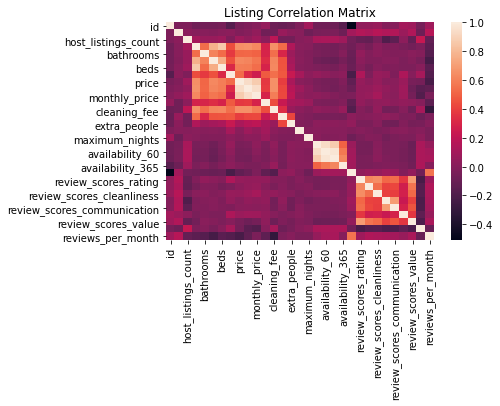

In [16]:
sns.heatmap(listings_df.corr());
plt.title('Listing Correlation Matrix');  

From the above heatmap, it looks like the numerical columns with the strongest correlation to price are the surrounding columns.<br>
Focusing on these specifically, produces the below heatmap.

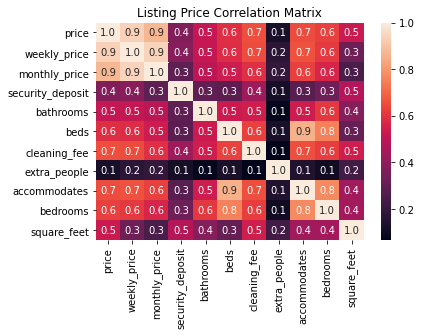

In [17]:
cols = ['price','weekly_price', 'monthly_price', 'security_deposit', 'bathrooms','beds',
                                      'cleaning_fee', 'extra_people','accommodates','bedrooms','square_feet']
sns.heatmap(listings_df[cols].corr(), annot=True, fmt=".1f");
plt.title('Listing Price Correlation Matrix');  

Or for an ordered list of the columns most correlated to price, the below list shows no surprises that monthly price would align since should be derived from price, and that the size of the property would influence the price.<br><br>
`monthly_price` and `weekly_price` should not be used though predict `price` though as they are derived from it.

#### New Column added:  `multihost` to answer Question 1 - "Are hosts with multiple listings concentrated in certain Seattle areas?"
Below I am adding a new column to listings_df with categorises the listing as belonging to a `multihost` 't/f', if the `host_listings_count` is greater than 1.

In [18]:
listings_df['multihost'] = listings_df['host_listings_count'].apply(abnb.multihost)
listings_df['multihost'].value_counts()

f    2181
t    1637
Name: multihost, dtype: int64

This can now be used to group the listings by `multihost` and look at whether the price varies for multihosts compared to hosts with only 1 listing.

#### Change dates to numbers
I have decided to convert the dates into length of time in months, turning them into continuous variables that can potentially influence `price` and `review_score_rating`. <br><br>The below cells convert date objects to dates, and then change dates to age in months using `abnb` function `date_to_months`.

In [19]:
#Date columns converted from objects to dates
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'])
listings_df['last_scraped'] = pd.to_datetime(listings_df['last_scraped'])

#New 'date as month' columns created based on the reformatted date columns using the date_to_months helper function
listings_df['months_hosting'] = listings_df.apply(lambda x: abnb.date_to_months(x['host_since'],
                                                                                x['last_scraped']), axis=1)
listings_df['months_first_review'] = listings_df.apply(lambda x: abnb.date_to_months(x['first_review'],
                                                                                x['last_scraped']), axis=1)
listings_df['months_last_review'] = listings_df.apply(lambda x: abnb.date_to_months(x['last_review'],
                                                                                x['last_scraped']), axis=1)
listings_df[['host_since','months_hosting']].head()

,host_since,months_hosting
0,2011-08-11,53.0
1,2013-02-21,35.0
2,2014-06-12,19.0
3,2013-11-06,26.0
4,2011-11-29,50.0


The above shows `host_since` now measured in months as new column `months_hosting`.

I will also be converting `calendar_updated` into months, though this needs preprocessing to change it into dates before I can use the above function to convert those dates into months.

In [20]:
listings_df.calendar_updated.value_counts().head()

today           706
2 weeks ago     347
3 weeks ago     300
2 months ago    281
a week ago      248
Name: calendar_updated, dtype: int64

The below code tokenizes the `calendar_updated` strings into lists. This is to separate the number value from the days/weeks/months values so that they can be handled separately by the `calendar_updated_date` function, which will compare them to the `last_scraped` and produce a new `calendar_updated_date` column I can then convert to months.

In [21]:
listings_df.calendar_updated = listings_df.calendar_updated.str.split(' ')
listings_df.calendar_updated.head()

0     [4, weeks, ago]
1             [today]
2     [5, weeks, ago]
3    [6, months, ago]
4     [7, weeks, ago]
Name: calendar_updated, dtype: object

In [22]:
#New date column created based on the reformatted calendar_updated using a helper function
listings_df['calendar_updated_date'] = listings_df.apply(lambda x: abnb.calendar_updated_date(x['calendar_updated'],
                                                                                x['last_scraped'],
                                                                                x['host_since']), axis=1)
#Then convert date to months as above
listings_df['calendar_updated_months'] = listings_df.apply(lambda x: abnb.date_to_months(x['calendar_updated_date'],
                                                                                x['last_scraped']), axis=1)

In [23]:
listings_df[['calendar_updated','calendar_updated_date','calendar_updated_months']].head()

,calendar_updated,calendar_updated_date,calendar_updated_months
0,"[4, weeks, ago]",2015-12-07,1
1,[today],2016-01-04,0
2,"[5, weeks, ago]",2015-11-30,2
3,"[6, months, ago]",2015-07-04,6
4,"[7, weeks, ago]",2015-11-16,2


Now I can drop these original date columns since I have used them to convert the other columns and they are no longer necessary.

In [24]:
listings_df = listings_df.drop(columns=['host_since','first_review','last_review','last_scraped',
                                        'calendar_updated_date','calendar_updated'])

#### Fill in the NaNs

Before I can build a linear regression model I will need to fill in all the NaNs in the numerical columns. My default would be to use the column mean, but first I need to review these columns and determine what a missing value means. Either 'zero' (as in there were 0 `reviews_per_month`) or does it just mean a lack of data (as with `square_feet`, because we can assume every property has square footage.)

In [25]:
listings_df.select_dtypes(include=['float', 'int']).describe()

,id,host_response_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,months_hosting,months_first_review,months_last_review,calendar_updated_months
count,3.818000e+03,3295.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,2009.000000,1517.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000,3816.000000,3191.000000,3191.00000,3818.000000
mean,5.550111e+06,94.886798,7.157757,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,788.481832,2613.336190,287.610397,61.710904,1.672603,10.667627,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919,27.872642,13.767471,2.85083,1.485333
std,2.962660e+06,11.866705,28.628149,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,532.352269,1722.267981,270.222690,48.830341,1.311040,17.585922,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348,18.724113,13.229769,3.68599,2.649347
min,3.335000e+03,17.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,100.000000,500.000000,95.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000,0.000000,0.000000,0.00000,0.000000
25%,3.258256e+06,98.000000,1.000000,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,455.000000,1512.000000,150.000000,25.000000,1.000000,0.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000,12.000000,5.000000,1.00000,0.000000
50%,6.118244e+06,100.000000,1.000000,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,650.000000,2200.000000,250.000000,50.000000,1.000000,0.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000,25.000000,8.000000,2.00000,1.000000
75%,8.035127e+06,100.000000,3.000000,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,950.000000,3150.000000,300.000000,83.000000,2.000000,20.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000,41.000000,19.000000,4.00000,2.000000
max,1.034016e+07,100.000000,502.000000,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,15.000000,300.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000,86.000000,79.000000,52.00000,73.000000


Replacing the NaNs for the below columns with 0 as I think that the lack of value was deliberate.

In [26]:
zero_cols = ['security_deposit', 'cleaning_fee', 'reviews_per_month','months_first_review','months_last_review']
for col in zero_cols:
    listings_df[col].fillna(0, inplace=True)

For all other numberical columns I am using the column mean as to fill in any null values, as they all appear to be continuous variables as opposed to boolean or other discrete variable.

In [27]:
num_cols = listings_df.select_dtypes(include=['float', 'int']).columns
for col in num_cols:
    listings_df[col].fillna((listings_df[col].mean()), inplace=True)
    
listings_df_original = listings_df.copy() #Copy of the listings_df before I remove the all non-numerical columns

**Amenities** is a will be necessary to answer question 2, and may also influence the price, but it is currently formatted as strings of property features. <br>These need to be split into separate columns so that I can model their individual impact.

In [28]:
listings_df.amenities.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                         45
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                                                                                                     11
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentia

Replacing the `"`, `{` and `}` symbols, and using `.split(',')` converts the strings into tidyier lists. 

In [29]:
listings_df.amenities = listings_df.amenities.replace('"', '', regex=True)
listings_df.amenities = listings_df.amenities.replace('{', '', regex=True)
listings_df.amenities = listings_df.amenities.replace('}', '', regex=True)

listings_df.amenities = listings_df.amenities.str.split(r'\s*,\s*')
listings_df.amenities.head()

0    [TV, Cable TV, Internet, Wireless Internet, Ai...
1    [TV, Internet, Wireless Internet, Kitchen, Fre...
2    [TV, Cable TV, Internet, Wireless Internet, Ai...
3    [Internet, Wireless Internet, Kitchen, Indoor ...
4    [TV, Cable TV, Internet, Wireless Internet, Ki...
Name: amenities, dtype: object

The next step is to group all of the different columns features into 1 non-duplicated set so that I can then see how many are common among listings and which are too rare to have much influence.

In [30]:
amenities_set = set()
for features in listings_df.amenities:
    for feature in features:
        amenities_set.add(feature)

print(amenities_set)

{'', 'Cable TV', 'Smoke Detector', 'Essentials', 'Internet', 'Hangers', 'Other pet(s)', 'Doorman', 'Pets live on this property', 'Heating', 'Breakfast', 'Cat(s)', 'Dryer', 'Elevator in Building', 'TV', 'Washer / Dryer', 'Hair Dryer', 'Shampoo', 'Wireless Internet', 'Free Parking on Premises', 'Pool', 'Buzzer/Wireless Intercom', 'First Aid Kit', 'Laptop Friendly Workspace', 'Pets Allowed', 'Family/Kid Friendly', 'Carbon Monoxide Detector', 'Safety Card', 'Kitchen', 'Washer', 'Fire Extinguisher', 'Lock on Bedroom Door', '24-Hour Check-in', 'Air Conditioning', 'Iron', 'Smoking Allowed', 'Gym', 'Indoor Fireplace', 'Wheelchair Accessible', 'Suitable for Events', 'Hot Tub', 'Dog(s)'}


In [31]:
amenities_set.discard('') #Discards the blank string element
len(amenities_set) #Check set length

41

The below cells creates a dataframe and bar chart based on the set of 41 distinct amenity values and sum up the frequency of occurances of the those values in the listings. 

In [32]:
#Creates a new amenities dataframe of the unique features which can then be looped through and 
#1 added when a the listing contains that feature
amenities_dict = {'amenities': list(amenities_set),'listing_count':  0 }
amenities_df = pd.DataFrame.from_dict(amenities_dict) 
for listing in listings_df.amenities:
    for feature in amenities_df.amenities:
        if feature in listing:
             amenities_df.loc[amenities_df['amenities'] == feature,'listing_count'] += 1

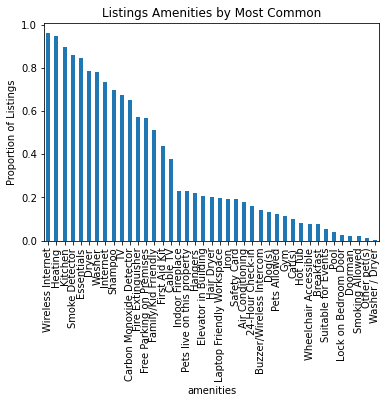

In [33]:
amenities_df.set_index('amenities',inplace=True)
(amenities_df.sort_values('listing_count', ascending=False)/listings_df.shape[0]).plot(kind='bar', legend=None);
plt.ylabel('Proportion of Listings')
plt.title("Listings Amenities by Most Common");    

Wireless Internet seems to be a staple nowadays and most properties have a separate washer and dryer, with only a few having a combination washer/dryer. Nothing too surprising here with the most common versus least, and helpfully there does not appear to be a need for tidying.

Now to create dummy variables from the updated amenities column and add those back into the original listings_df.

In [34]:
#Create a copy 1st rather than add straight onto the original because duplicate rows will be created
# which will need to be grouped before adding back to the data
data = listings_df[['id','amenities']].copy() 

data = pd.get_dummies(data.set_index('id').explode('amenities'), prefix='', 
                        prefix_sep='',dtype=int).groupby(by=['id']).sum() #group by ids and sum dummy columns
data

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet(s),Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3335,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1
4291,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1
5682,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
6606,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
7369,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332096,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
10334184,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
10339144,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1


In [35]:
#Merge the above grouped data with listings_df to add the features to the original dataset and drop amenities and ''
listings_df = pd.merge(listings_df.set_index('id'), data, right_index=True, left_index=True, how = 'left')
listings_df.drop(columns=['amenities',''])
listings_df.shape

(3818, 119)

#### Property Picture URLs
Listings_df has additional pictures for 91.6% of the listings. As mentioned earlier, since I cannot use the pictures themselves I will add a marker for whether or not certain listings have more than just the main property picture, then drop all the picture URLs.<br><br>
The below code uses a helper function to add a new t/f column to listings_df.

In [36]:
listings_df['extra_pictures'] = listings_df['thumbnail_url'].isnull().apply(abnb.has_value)

In [37]:
listings_df = listings_df.drop(columns=['thumbnail_url','medium_url','picture_url','xl_picture_url',
                                        'host_thumbnail_url','host_picture_url'])

#### Other catergorical columns
Of the remaining categorical columns listed below `name`, `summary`, `space`, `description`, `neighborhood_overview`, `notes`, `transit`, `host_about` are free text fields which contain a lot of property feature information already available in other columns. While there may be some additional info in these columns, I have found it too complicated to extract. <br> <br>When I split and added `summary` to a word dictionary & word counter, I found around 8000 words, with a high frequency of common words like 'the', a lot of 1 occurance words like 'sally', and with a lot of possibily useful words in between that would be hard to put into context on their own (e.g 'windows', 'rooftop' and 'located'). <br> <br>For this reason I will exclude these columns from this analysis, though they could be further explored later.

In [38]:
cat_listings_df = listings_df.select_dtypes(include=['object'])
cat_listings_df.columns

Index(['listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'host_url', 'host_name',
       'host_location', 'host_about', 'host_response_time',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'zipcode', 'smart_location',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'security_deposit_req', 'cleaning_fee_req',
       'review_scores_rating_available', 'multihost', 'extra_pictures'],
      dtype='object')

Of the other columns, the host specific information seems unnecessary, except for the `host_response_time` which may influence reviews/renters, and the neighbourhood information has handily been cleansed so the `street` and `neighbourhood` can be dropped.<br><br>
For modelling `price` in the next stage I will be dropping any too detailed or unnecessary categorical columns though 1st I will take a copy for some so that I can display my findings for question 1.

In [39]:
listings_df_original = listings_df.copy() #Copy of the listings_df before I remove the all non-numerical columns

drop_cols = ['listing_url', 'name', 'summary', 'space', 'description','street', 'neighbourhood',
       'neighborhood_overview', 'notes', 'transit', 'host_url', 'host_name','smart_location', 'amenities',
       'host_location', 'host_about', 'host_neighbourhood', 'host_verifications','is_location_exact',
         'host_identity_verified','neighbourhood_group_cleansed','zipcode']
listings_df = listings_df.drop(columns = drop_cols)

So the catergorical we are left with are...

In [40]:
cat_listings_df = listings_df.select_dtypes(include=['object'])
cat_listings_df.columns

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'security_deposit_req', 'cleaning_fee_req',
       'review_scores_rating_available', 'multihost', 'extra_pictures'],
      dtype='object')

These will now be used to create dummy variables. I also decided to allow NaN dummy columns to be created in case the lack of categorical data is significant.

In [41]:
# for each column add dummy col, drop original column
for col in cat_listings_df.columns: 
    listings_df = pd.concat([listings_df.drop(col, axis=1), pd.get_dummies(listings_df[col], 
                                     prefix=col, prefix_sep='_',dummy_na=True, drop_first=True, dtype=int)], axis=1)

In [42]:
drop_cols = [''] #drop unnecessary space dummy column 
listings_df = listings_df.drop(columns = drop_cols)

### 4.Data Modelling

#### Price Prediction Model

I will use all the numerical variables I have cleansed compiled to create a linear regression model to see how well we can use the available data to predict price.

In [43]:
listings_df.shape

(3818, 213)

1st to take a quick look at the available columns that will be used for the model and check that they are all numerical and none should be excluded.

In [44]:
pd.set_option('max_rows', None)
#Using the abnb.summerize_columns function again to view dtypes, column counts and unique counts
listings_info = abnb.summerize_columns(listings_df)
listings_info

,colName,non-null values,pop percentage,unique,dtype
0,host_response_rate,3818,1.0,46,float64
1,host_listings_count,3818,1.0,28,float64
2,accommodates,3818,1.0,15,int64
3,bathrooms,3818,1.0,13,float64
4,bedrooms,3818,1.0,9,float64
5,beds,3818,1.0,12,float64
6,square_feet,3818,1.0,48,float64
7,price,3818,1.0,273,float64
8,weekly_price,3818,1.0,396,float64
9,monthly_price,3818,1.0,357,float64


In [45]:
pd.reset_option('max_rows')

It does not make sense to include the `weekly_price` and `monthly_price` columns, since `price` they are partially derived from it, so I will be excluding them from the linear regression model.<br><br>The below code calls the `abnb.linear_model` function which will take in the listings_df dataframe, the columns I wish to exclude for now, the test size, and random state. It also takes a subset of listings_df columns I could choose to use instead of the entire 211 columns available from listings_df, which would be the default.<br><br>**1st Run:** The below model will return the rsquared training and test scores for training the model on the all 211 numerical columns.

In [46]:
drop_cols = ['weekly_price','monthly_price']
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = abnb.linear_model(listings_df.drop(
                                                columns =drop_cols),'price', [] , test_size = .30, random_state=42)

In [47]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}."
                                                                .format(round(train_score,4), round(test_score,4)))

The rsquared on the training data was 0.6496.  The rsquared on the test data was -6.0530378391277955e+25.


Okay that's awful. The training r2 score of 0.645 is not bad, but that the test data has scored a negative r2 value means that the current model is worse at predicting price than just taking the training data y mean. This is probably because I have too used many explanatory variables. 211 variables is a bit excessive.<br><br>**2nd Run:** Below I will try this again using a subset of explanatory columns. The top 20 correlated to price.

In [48]:
#Create a list of columns correlated to price, sort by values descending and then take the top 21. 
#Then remove 'price' leaving the top 20 remaining
top_20_corr = list(listings_df.drop(columns = drop_cols).corr().abs().unstack().sort_values(
                                                                            ascending=False)['price'][:21].index)
top_20_corr.remove('price')

In [49]:
top_20_corr

['accommodates',
 'bedrooms',
 'beds',
 'cleaning_fee',
 'bathrooms',
 'guests_included',
 'room_type_Private room',
 'security_deposit',
 'Family/Kid Friendly',
 'Cable TV',
 'cancellation_policy_strict',
 'TV',
 'reviews_per_month',
 'extra_pictures_t',
 'security_deposit_req_t',
 'cleaning_fee_req_t',
 'room_type_Shared room',
 'Indoor Fireplace',
 'Air Conditioning',
 'extra_people']

Rerun the model model using the chosen list of columns.

In [50]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = abnb.linear_model(listings_df, 'price', 
                                                                top_20_corr, test_size = .30, random_state=42)

print("Using the top {} variables, the training data rsquared was {}.  The test data rsquared was {}."
                                                            .format(20,round(train_score,4), round(test_score,4)))

Using the top 20 variables, the training data rsquared was 0.5625.  The test data rsquared was 0.575.


This is better since the training and r2 score and much closer. The training score has decreased slightly though.<br><br>**3rd Run:** Increased size of list to the top 100.

In [51]:
top_100_corr = list(listings_df.drop(columns = drop_cols).corr().abs().unstack().sort_values(
                                                                            ascending=False)['price'][:101].index)
top_100_corr.remove('price')

test_score, train_score, lm_model, X_train, X_test, y_train, y_test = abnb.linear_model(listings_df, 'price', 
                                                                top_100_corr, test_size = .30, random_state=42)

print("Using the top {} variables, the training data rsquared was {}.  The test data rsquared was {}."
                                                            .format(100,round(train_score,4), round(test_score,4)))

Using the top 100 variables, the training data rsquared was 0.6234.  The test data rsquared was 0.6192.


**4th Run:** Increased size of list to the top 174.

In [52]:
top_181_corr = list(listings_df.drop(columns = drop_cols).corr().abs().unstack().sort_values(
                                                                            ascending=False)['price'][:182].index)
top_181_corr.remove('price')

test_score, train_score, lm_model, X_train, X_test, y_train, y_test = abnb.linear_model(listings_df, 'price', 
                                                                top_181_corr, test_size = .30, random_state=42)
print("Using the top {} variables, the training data rsquared was {}.  The test data rsquared was {}."
                                                            .format(181,round(train_score,4), round(test_score,4)))

Using the top 181 variables, the training data rsquared was 0.643.  The test data rsquared was 0.6258.


Using the top 181 variables has improved both the training and test scores.<br><br>**5th Run:** Increased size of list to the top 174.

In [53]:
top_184_corr = list(listings_df.drop(columns = drop_cols).corr().abs().unstack().sort_values(
                                                                            ascending=False)['price'][:185].index)
top_184_corr.remove('price')

test_score, train_score, lm_model, X_train, X_test, y_train, y_test = abnb.linear_model(listings_df, 'price', 
                                                                top_184_corr, test_size = .30, random_state=42)
print("Using the top {} variables, the training data rsquared was {}.  The test data rsquared was {}."
                                                            .format(184,round(train_score,4), round(test_score,4)))

Using the top 184 variables, the training data rsquared was 0.644.  The test data rsquared was -1.76272289799254e+24.


At over 181 explanatory variables the test r2 score stops growing, and at over 183 the test r2 score goes negative, even though the training score continues to increase. 

### 5.Results

#### Question 3: Which factors contribute the most to Seattle's AirBNB property rental price? 

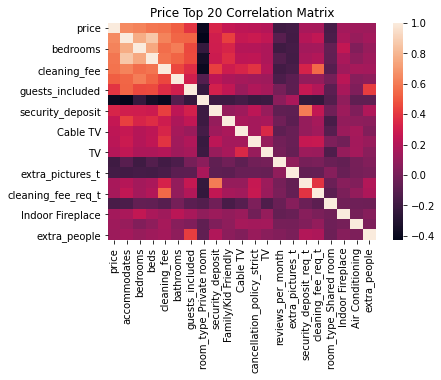

In [54]:
cols = ['price'] + top_20_corr
sns.heatmap(listings_df[cols].corr()); #Heatmap of the top 20 correlated variables used in the above model + price
plt.title('Price Top 20 Correlation Matrix');  

In [55]:
price_corr = listings_df.drop(columns=drop_cols).corr().abs().unstack().sort_values(
                                                                    ascending=False).drop_duplicates()['price'].head()
cm = sns.light_palette("red", as_cmap=True)

pd.DataFrame(price_corr, columns=['Top 5 Price Drivers']).style.background_gradient(cmap=cm)

,Top 5 Price Drivers
accommodates,0.652218
beds,0.589306
cleaning_fee,0.576423
bathrooms,0.516017
guests_included,0.392875


The above heatmap shows the top 20 variables which correlated to `price` and which, on their own, where able to drive an rsquared test score of 0.575, contributing 92% of the end prediction model score. Best drivers were: number of people the property accommodates, number of beds, the cleaning fee, number of bathrooms and guested who can be added. Room type is also influencial though not as much as I expected. And property type (house vs condo) did not make the top 20.<br>
#### Question 3b. How well can we predict a property's rental price?
From the 4th run of the above price prediction model, I have been able to achieve a best test r2 score of 0.6258. This is not bad, and means that I could predict future prices for new listing with some degree of confidence, though does also imply that there are other factors contributing to price that I have not been able to include in the model.

**Price Prediction Best Model - 4th Run**

In [56]:
top_181_corr = list(listings_df.drop(columns = drop_cols).corr().abs().unstack().sort_values(
                                                                            ascending=False)['price'][:182].index)
top_181_corr.remove('price')

test_score, train_score, lm_model, X_train, X_test, y_train, y_test = abnb.linear_model(listings_df, 'price', 
                                                                top_181_corr, test_size = .30, random_state=42)
print("Using the top {} variables, the training data rsquared was {}.  The test data rsquared was {}."
                                                            .format(181,round(train_score,4), round(test_score,4)))

Using the top 181 variables, the training data rsquared was 0.643.  The test data rsquared was 0.6258.


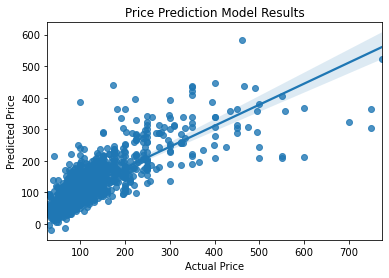

In [57]:
sns.regplot(x=y_test, y=lm_model.predict(X_test))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title('Price Prediction Model Results'); 

#### Question 1a: Does the listing price vary for hosts with multiple listings compared to hosts with only 1 listing. 

Below I use the `multihost` column I created earlier to group the listings by single vs multihosts and look at whether the price varies for multihosts compared to hosts with only 1 listing.

In [58]:
host_grp = listings_df_original.groupby(['multihost']).agg({'price': ['count','mean','median', 'min', 'max'],
                                        'review_scores_rating': ['mean','median', 'min', 'max']}) 
host_grp.style.format(precision=0,
                           formatter={('price','mean'): "${:.2f}",
                                     ('price','median'): "${:.2f}",
                                      ('price','min'): "${:.2f}",
                                      ('price','max'): "${:.2f}"})

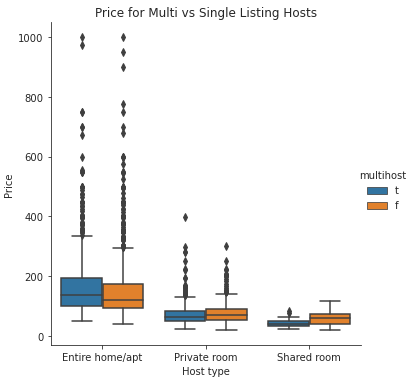

In [59]:
with sns.axes_style(style='ticks'):
    g=sns.catplot(x='room_type',y='price',hue='multihost',data=listings_df_original,kind='box')
    g.set_axis_labels('Host type','Price')
    plt.title('Price for Multi vs Single Listing Hosts');  

Looking at the above table, both average price and review rating are very similar for multi and single property hosts. But when we break the range of prices down by room_type we can see that for 'Entire home/apt' multihosts are a bit more expensive within the 25th to 75th percentile, and have a higher median. <br>
#### Question 1b: Are multihost concentrated in certain Seattle areas?<br>
The below cells create a new dataframe limited to multihost_listings and use this to create summary table of the top 10 neighbourhoods multihosts have listings.

In [60]:
multihost_listings = listings_df_original[listings_df_original['multihost']=='t']

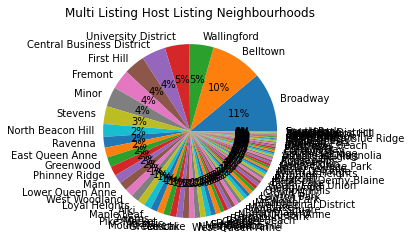

In [61]:
multihost_grp = multihost_listings.groupby(['neighbourhood_cleansed']).agg({'price':'count'}).sort_values(by=['price'],
                                                        ascending=False)/multihost_listings.shape[0]*100

multihost_grp.plot(x='neighbourhood_cleansed',y='price',kind='pie',legend=False, autopct='%1.0f%%');
plt.xlabel('')
plt.ylabel('')
plt.title('Multi Listing Host Listing Neighbourhoods');  

In [62]:
multihost_grp[:10].style.format('{:.0f}%')

,price
neighbourhood_cleansed,
Broadway,11%
Belltown,10%
Wallingford,5%
University District,5%
Central Business District,4%
First Hill,4%
Fremont,4%
Minor,4%
Stevens,3%


Of the top 10 neighbourhoods, Broadway and Beltown are the 2 with the highest concentration of multihost properties, with the above list making up 52% of the neighbourhoods in Seattle with multihost properties.

#### Question 2. Do renters prefer certain property features or amenties?


In [63]:
#Creating a new dataframe specific to original review_scores_rating, filtering out the filled values
r_listings_df = listings_df[listings_df['review_scores_rating_available_t']==1]
r_listings_df.shape

(3171, 213)

In [64]:
review_corr = r_listings_df.corr().abs().unstack().sort_values(ascending=False)[
                                                                                'review_scores_rating'][:7]
cm = sns.light_palette("blue", as_cmap=True)

pd.DataFrame(review_corr.drop(['review_scores_rating','review_scores_value']), columns=[
                                         'Correlation to review_scores_rating']).style.background_gradient(cmap=cm)

,Correlation to review_scores_rating
review_scores_cleanliness,0.641622
review_scores_accuracy,0.619315
review_scores_communication,0.540032
review_scores_checkin,0.520164
review_scores_location,0.367621


Looking at the above list of top 6 variables correlated to `review_scores_rating` we can see that the other review scores like cleanliness, accuracy of reviews, communication with host, checkin process and location drive the overall listing review rating, which would be expected since it is calculated from them. It is useful though to see that of the ratings cleanliness and accuracy are the most critical to a positive overall rating and therefore most important to renters.<br><br>
I think though that it might be more useful to use the `reviews_per_month` as a target measure for renter's interest, if I take it as an indicator of bookings. The below graphs show the difference in density between the 2 variables, with `reviews_per_month` having a wider distribution compared to `review_scores_rating` which has most of the listings scoring between 90%-100%.

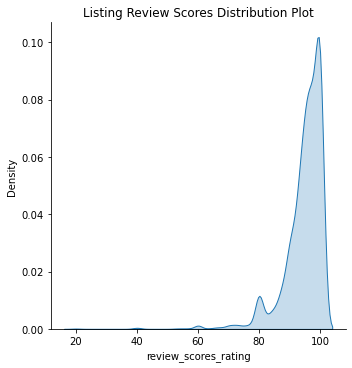

In [65]:
sns.displot(r_listings_df, x='review_scores_rating', kind="kde", fill=True);
plt.title('Listing Review Scores Distribution Plot');    

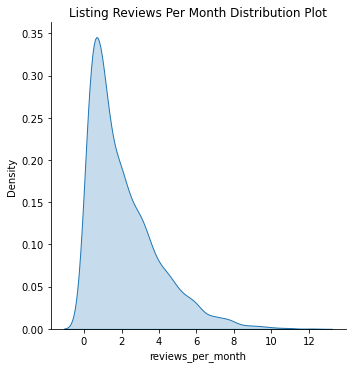

In [66]:
sns.displot(r_listings_df, x='reviews_per_month', kind="kde", fill=True);
plt.title('Listing Reviews Per Month Distribution Plot');  

The below list or top 20 variables uses `reviews_per_month` as the target variable for correlation.

In [67]:
top_20_corr = list(listings_df.drop(columns = drop_cols).corr().abs().unstack().sort_values(
                                                                            ascending=False)['price'][:21].index)

In [68]:
review_corr = r_listings_df.drop(columns='number_of_reviews').corr().abs().unstack().sort_values(
                                                                        ascending=False)['reviews_per_month'][:20]
#sns.heatmap(review_corr, annot=True, fmt=".1f");
cm = sns.light_palette("green", as_cmap=True)

reviews_corr_results = pd.DataFrame(review_corr.drop(['reviews_per_month']), columns=[
                                        'Correlation to reviews_per_month']).style.background_gradient(cmap=cm)
reviews_corr_results

,Correlation to reviews_per_month
months_last_review,0.385137
host_response_time_within an hour,0.340530
calendar_updated_months,0.274906
instant_bookable_t,0.270239
host_is_superhost_t,0.268950
cleaning_fee,0.251434
bedrooms,0.228867
host_response_time_nan,0.227833
price,0.216756
Shampoo,0.210179


The above list shows that of the listing columns: speedy host response time, recent calendar updates, instant booking facillities, and super host, whether there is a cleaning fee, number of bedrooms and the price are influencial to renters. These properties appear to be of more interest than any of the amenities. `months_last_review` should possibly be ignored as could be linked to the reviews_per_month count. <br><br>
Of the amenities shampoo, essentials, hairdryer and a laptop friendly workspace appear to be the most important.<br> It is worth noting that the Internet / Wireless Internet appear to have low correlation this is partly due to most listings having it as standard. It is therefore difficult to separate it's impact on renters.

In [69]:
pd.DataFrame(review_corr.drop(['reviews_per_month','months_last_review','calendar_updated_months']), columns=[
                                        'Correlation to reviews_per_month'])[:12].style.background_gradient(cmap=cm)

,Correlation to reviews_per_month
host_response_time_within an hour,0.340530
instant_bookable_t,0.270239
host_is_superhost_t,0.268950
cleaning_fee,0.251434
bedrooms,0.228867
host_response_time_nan,0.227833
price,0.216756
Shampoo,0.210179
host_response_time_within a day,0.173416
Essentials,0.170533


**Review Comments:** The review data would also be a useful source of issues or features that would be of interest to renters.<br><br>
The below code filters the listings on those with the lowest ratings. This is then used to merge with the `review_df` dataset and pull out only those comments linked to low scoring listings.

In [70]:
negative_listings = r_listings_df[r_listings_df['review_scores_rating']<50]
negative_listings.shape

(5, 213)

In [71]:
neg_reviews = negative_listings.merge(reviews_df, left_on='id', right_on='listing_id')
neg_reviews['comments']

0    I stayed at Vivian's place since it was locate...
1    Unfortunately my experience with the Belltown ...
2    TL;DR - This place has a ton of potential, but...
3    The host canceled this reservation the day bef...
4    The host canceled this reservation the day bef...
5    A beautiful, clean house in a convenient locat...
6    Tim was very responsive and clear in his instr...
7    Tim was a good host and was very responsive to...
Name: comments, dtype: object

From the above list of comments we can see a couple renters have had negative experiences.<br>Using the below abnb function we have a look at the words that make up these reviews. The `abnb.word_count` function takes in the dataframe, the string column of interest, and also a minimum threshold for the number of words we would be interested in. This is to exclude rare words like names of people, if possible.

In [72]:
neg_dict = abnb.word_count(neg_reviews,'comments',3) 

Making 3 the limit to weed out rare words we are left with the below graph and list of frequency words from these comments.

/Users/alciamoncrieffe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/alciamoncrieffe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


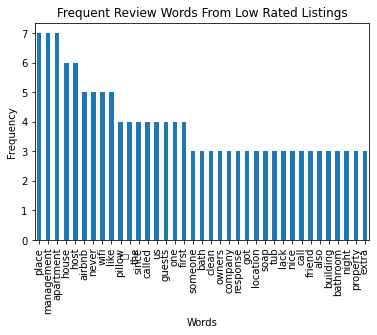

In [73]:
neg_dict.sort_values(by=['count'],ascending=False).plot(kind='bar', legend=None);
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequent Review Words From Low Rated Listings'); 

The above list shows a number of words that unfortunately do not mean a lot out of context. We could make some assumptions that these words mostly indicate problems these renters have experienced during their stay but since we only have 7 reviews to work with linked to listing scoring under 50%, it would be better to pursue a larger dataset of negative reviews.

In [74]:
neg_dict.sort_values(by=['count'],ascending=False).index

Index(['place', 'management', 'apartment', 'house', 'host', 'airbnb', 'never',
       'wifi', 'like', 'pillow', '\r\nthe', 'since', 'called', 'us', 'guests',
       'one', 'first', 'someone', 'bath', 'clean', 'owners', 'company',
       'response', 'got', 'location', 'soap', 'tub', 'lack', 'nice', 'call',
       'friend', 'also', 'building', 'bathroom', 'night', 'property', 'extra'],
      dtype='object')